In [6]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [7]:
def load_data(version, mag, path='../others/data_50_60_2008_2016/data/data_gif/'):
    data1_2008 = pd.read_csv(path+'t_minus_1/gif_data_2008_'+version+'_'+mag+'.csv')
    data1_2016 = pd.read_csv(path+'t_minus_1/gif_data_2016_'+version+'_'+mag+'.csv')
    data2_2008 = pd.read_csv(path+'t_minus_2/gif_data_2008_'+version+'_'+mag+'.csv')
    data2_2016 = pd.read_csv(path+'t_minus_2/gif_data_2016_'+version+'_'+mag+'.csv')
    data3_2008 = pd.read_csv(path+'t_minus_3/gif_data_2008_'+version+'_'+mag+'.csv')
    data3_2016 = pd.read_csv(path+'t_minus_3/gif_data_2016_'+version+'_'+mag+'.csv')
    
    data = pd.DataFrame({'t-1': data1_2008['gif'], 't-2': data2_2008['gif'], 't-3': data3_2008['gif']})
    data = data.append(pd.DataFrame({'t-1': data1_2016['gif'], 't-2': data2_2016['gif'], 't-3': data3_2016['gif']}),ignore_index=True)
    data = data.drop([0])
    data['t'] = data1_2008['gif'].append(data1_2016['gif'],ignore_index=True)
    data['time'] = data1_2008['time'].append(data1_2016['time'],ignore_index=True)
    data = data.dropna()
    return data

def preprocessing(data, test_size_param=0.33):
    X_train, X_test, y_train, y_test = train_test_split(data[['t-1','t-2','t-3']].values,
                                                        data[['t']].values, test_size=test_size_param, random_state=42)
    X_train = tf.constant(X_train, np.float32)
    y_train = tf.constant(y_train, np.float32)
    X_test = tf.constant(X_test, np.float32)
    y_test = tf.constant(y_test, np.float32)

    return (X_train, X_test, y_train, y_test)

def do_the_graphics(target, predict, title):
    plt.figure()
    plt.title(title+' GIF')
    plt.plot(range(len(target)), target, alpha=1, label='y_test')
    plt.plot(range(len(target)), predict, alpha=0.5, label='y_predict')
    plt.legend()
    plt.show()

    plt.figure()
    plt.title(title+' RMSE')
    plt.plot(range(len(target)), np.sqrt(tf.keras.losses.mse(target, predict)))
    plt.show()

    plt.figure()
    plt.title(title+' MAE')
    plt.plot(range(len(target)), tf.keras.losses.mae(target, predict))
    plt.show()

def DFANN_model(X_train, X_test, y_train, y_test, name):
    neuron_number = 12 # 12 neurons in each Dense layer
    i_data_dim = 3 # 3 GIFs as input

    model_DFANN = Sequential()
    model_DFANN.add(Dense(neuron_number, activation='relu', input_dim=i_data_dim))
    model_DFANN.add(Dense(neuron_number, activation='relu'))
    model_DFANN.add(Dense(neuron_number, activation='relu'))
    model_DFANN.add(Dense(neuron_number, activation='relu'))
    model_DFANN.add(Dense(1, activation='linear'))

    model_DFANN.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mae', 'mse'])

    print(model_DFANN.summary())
    
    history_train = model_DFANN.fit(X_train, y_train, epochs=100, verbose=1)
    y_predict = model_DFANN.predict(X_test)
    y_trainpredict = model_DFANN.predict(X_train)
    
    do_the_graphics(y_test, y_predict, 'GIF '+name+': test vs predicted')
    do_the_graphics(y_train, y_trainpredict, 'GIF '+name+': train vs train predicted')
    
def plot_history(history, name):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.title('GIF '+name+': MAE vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.title('GIF '+name+': RMSE vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Square Error')
    plt.plot(hist['epoch'], hist['rmse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()
    
def DFANN_model_w_valset(X_train, X_test, y_train, y_test, name):
    neuron_number = 12 # 12 neurons in each Dense layer
    i_data_dim = 3 # 3 GIFs as input

    model_DFANN = Sequential()
    model_DFANN.add(Dense(neuron_number, activation='relu', input_dim=i_data_dim))
    model_DFANN.add(Dense(neuron_number, activation='relu'))
    model_DFANN.add(Dense(neuron_number, activation='relu'))
    model_DFANN.add(Dense(neuron_number, activation='relu'))
    model_DFANN.add(Dense(1, activation='linear'))

    model_DFANN.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mae', 'mse'])

    print(model_DFANN.summary())
    
    history = model_DFANN.fit(X_train, y_train, epochs=100, validation_split = 0.2, verbose=1)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist['rmse'] = np.sqrt(hist['rmse'].values)
    
    y_predict = model_DFANN.predict(X_test)
    y_trainpredict = model_DFANN.predict(X_train)
    
    do_the_graphics(y_test, y_predict, 'GIF '+name+': test vs predicted')
    do_the_graphics(y_train, y_trainpredict, 'GIF '+name+': train vs train predicted')
    plot_history(history, name)
    
def main(names):
    for name,mag in names:
        df = load_data(name,mag)
        X_train, X_test, y_train, y_test = preprocessing(df)
        DFANN_model(X_train, X_test, y_train, y_test, name+mag)
        DFANN_model_w_valset(X_train, X_test, y_train, y_test, name+mag)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 12)                48        
_________________________________________________________________
dense_11 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_12 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_13 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 13        
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
None
Train on 2463 samples
Epoch 1/100
2463/2463 [==============================] - 1s 206us/sample - loss: 1.6911 - mae: 

2463/2463 [==============================] - 0s 66us/sample - loss: 1.6818e-04 - mae: 0.0086 - mse: 1.6818e-04
Epoch 61/100
2463/2463 [==============================] - 0s 66us/sample - loss: 1.1816e-04 - mae: 0.0063 - mse: 1.1816e-04
Epoch 62/100
2463/2463 [==============================] - 0s 68us/sample - loss: 1.2698e-04 - mae: 0.0060 - mse: 1.2698e-04
Epoch 63/100
2463/2463 [==============================] - 0s 60us/sample - loss: 1.5583e-04 - mae: 0.0074 - mse: 1.5583e-04
Epoch 64/100
2463/2463 [==============================] - 0s 60us/sample - loss: 1.3266e-04 - mae: 0.0068 - mse: 1.3266e-04
Epoch 65/100
2463/2463 [==============================] - 0s 62us/sample - loss: 1.5478e-04 - mae: 0.0077 - mse: 1.5478e-04
Epoch 66/100
2463/2463 [==============================] - 0s 59us/sample - loss: 2.1700e-04 - mae: 0.0088 - mse: 2.1700e-04
Epoch 67/100
2463/2463 [==============================] - 0s 66us/sample - loss: 1.7712e-04 - mae: 0.0075 - mse: 1.7712e-04
Epoch 68/100
2463/246

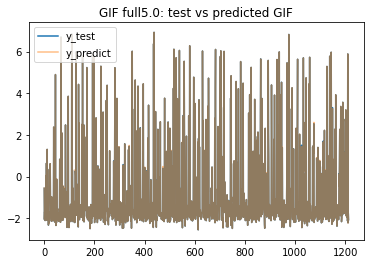

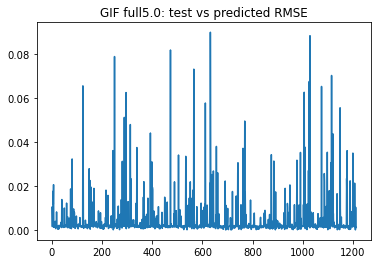

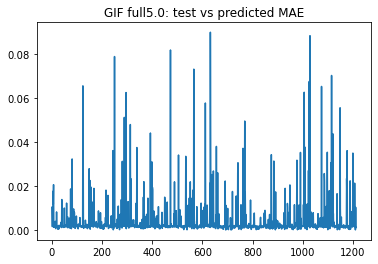

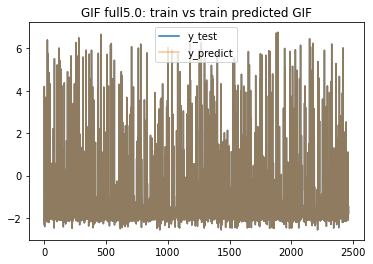

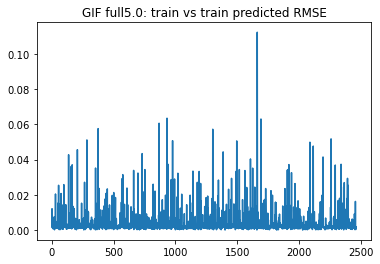

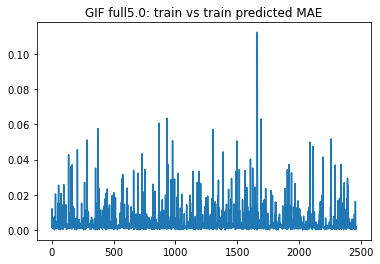

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 12)                48        
_________________________________________________________________
dense_16 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_17 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_18 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 13        
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
None
Train on 1970 samples, validate on 493 samples
Epoch 1/100
1970/1970 [==============================] - 1s 272us/samp

1970/1970 [==============================] - 0s 91us/sample - loss: 6.4216e-04 - mae: 0.0105 - mse: 6.4216e-04 - val_loss: 0.0013 - val_mae: 0.0113 - val_mse: 0.0013
Epoch 43/100
1970/1970 [==============================] - 0s 88us/sample - loss: 7.4608e-04 - mae: 0.0135 - mse: 7.4608e-04 - val_loss: 0.0013 - val_mae: 0.0131 - val_mse: 0.0013
Epoch 44/100
1970/1970 [==============================] - 0s 72us/sample - loss: 6.0539e-04 - mae: 0.0111 - mse: 6.0539e-04 - val_loss: 0.0012 - val_mae: 0.0102 - val_mse: 0.0012
Epoch 45/100
1970/1970 [==============================] - 0s 74us/sample - loss: 6.2810e-04 - mae: 0.0117 - mse: 6.2810e-04 - val_loss: 0.0012 - val_mae: 0.0145 - val_mse: 0.0012
Epoch 46/100
1970/1970 [==============================] - 0s 78us/sample - loss: 0.0011 - mae: 0.0196 - mse: 0.0011 - val_loss: 0.0012 - val_mae: 0.0113 - val_mse: 0.0012
Epoch 47/100
1970/1970 [==============================] - 0s 71us/sample - loss: 5.5636e-04 - mae: 0.0112 - mse: 5.5636e-04 - 

1970/1970 [==============================] - 0s 70us/sample - loss: 2.2296e-04 - mae: 0.0080 - mse: 2.2296e-04 - val_loss: 5.4198e-04 - val_mae: 0.0187 - val_mse: 5.4198e-04
Epoch 87/100
1970/1970 [==============================] - 0s 70us/sample - loss: 2.6608e-04 - mae: 0.0103 - mse: 2.6608e-04 - val_loss: 2.3978e-04 - val_mae: 0.0081 - val_mse: 2.3978e-04
Epoch 88/100
1970/1970 [==============================] - 0s 67us/sample - loss: 1.9982e-04 - mae: 0.0078 - mse: 1.9982e-04 - val_loss: 2.5858e-04 - val_mae: 0.0082 - val_mse: 2.5858e-04
Epoch 89/100
1970/1970 [==============================] - 0s 67us/sample - loss: 1.7304e-04 - mae: 0.0072 - mse: 1.7304e-04 - val_loss: 2.1341e-04 - val_mae: 0.0057 - val_mse: 2.1341e-04
Epoch 90/100
1970/1970 [==============================] - 0s 70us/sample - loss: 1.5375e-04 - mae: 0.0066 - mse: 1.5375e-04 - val_loss: 2.5636e-04 - val_mae: 0.0072 - val_mse: 2.5636e-04
Epoch 91/100
1970/1970 [==============================] - 0s 70us/sample - los

NameError: name 'history' is not defined

In [8]:
names = [('full','5.0')]
main(names)